# Face Detection and Recognition

Face detection finds faces in photos or video frames while facial recognition identifyis the faces detected.

## Face Detection with Viola-Jones

One of the fastest and most popular algorithms for detecting faces in photos. The algorithm keys on the relative intensities of adjacent blocks of pixels. For example the average pixel intensity in a rectangle around the eyes is typically darker than the average pixel intensity in a rectangle immediately below that area. The presence of many such Haar-like features in a frame at the right locations is an indicator that the frame contains a face. Viola-Jones works by sliding windows of various sizes over an image looking for frames with Haar-like features in the right places. At each stop, the pixels in the window are scaled to a specified size (typically 24 x 24) and features are extracted and fed into a binary classifier that returns positive indicating the frame contains a face or negative indicating it does not. A frame of 24x24 pixels contains more than 160.000 combinations of rectangles representing potential Haar-like features. The model computes only those that the classifier requires. The classifier is several binary classifiers arranged in stages, the first stage requires only one feature, the second might require 10 features and the third might require 20 features and features are extracted and passed to the next stage only if the previous stage returns a positive result giving rise to the term cascade classifier. This is a design pattern known as high recall then percison because individual stages are tuned for high recall but the cumulative effect is one of high percision.

## Using OpenCV implementation of Viola-Jones

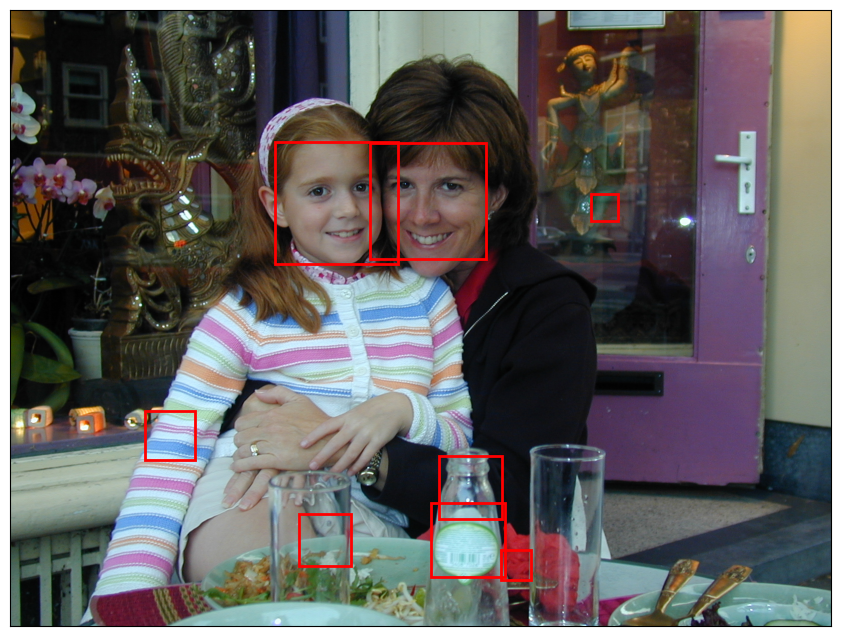

In [1]:
import cv2
from cv2 import CascadeClassifier
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline

image = plt.imread('Data/Amsterdam.jpg')
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'xticks': [], 'yticks':[]})
ax.imshow(image)

model = CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = model.detectMultiScale(image)

for face in faces:
    x, y, w, h = face
    rect = Rectangle((x,y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

CascadeClassifier detected two faces but has a numger of false positives. One way to fix this is to use the minNeighbors parameter, the default is 3 but incereasing it makes the CascadeClassifier more selective.

In [2]:
faces = model.detectMultiScale(image, minNeighbors=20)

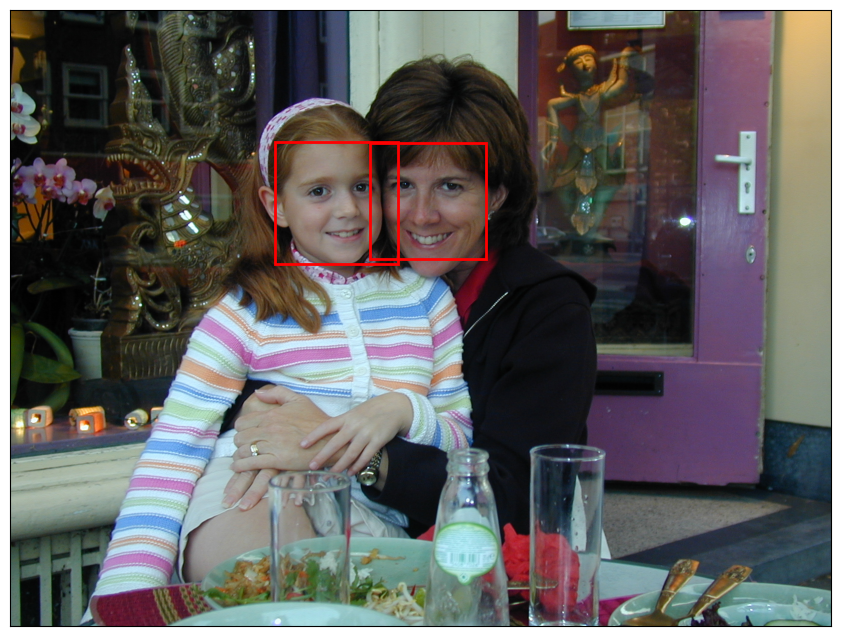

In [3]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'xticks': [], 'yticks':[]})
ax.imshow(image)

for face in faces:
    x, y, w, h = face
    rect = Rectangle((x,y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

## Face Degtection with Convolutional Neural Networks

Deep-learning methods are more computationally expensive but often do a better job at detecting faces than Viola-Jones. Multitask cascaded convolutional neural networks or MTCNNs have proven adept at face detection. A MTCNN uses three CNNs arranged in a series to detect faces. The first one is called the Proposal Network or P-net, it is a shallow CNN and it searches the image at various resolutions looking for features indicative of faces. Rectangles identified by P-Net are combined to form candidate face rectangles and are input to the Refine Network or R-Net which is a deeper CNN that examines each rectangle more closely. Finally the outputs from R-Net is input to the Output Network or O-Net which further filters candidate rectangles and identifies facial landmarks. MTCNNs are multiclass because they produce three outputs indicating the confidence that the rectangle contains a face and two regression outputs locating the face and facial landmarks.

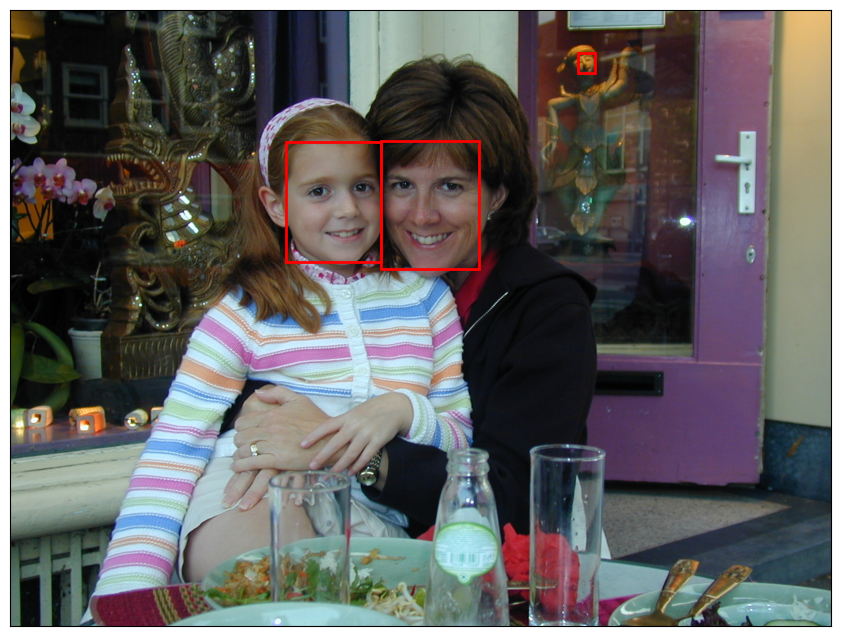

In [12]:
from mtcnn.mtcnn import MTCNN

fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

detector = MTCNN()
faces = detector.detect_faces(image)

for face in faces:
    x, y, w, h = face['box']
    rect = Rectangle((x,y), w, h, color='red', fill=False, lw=2)
    ax.add_patch(rect)

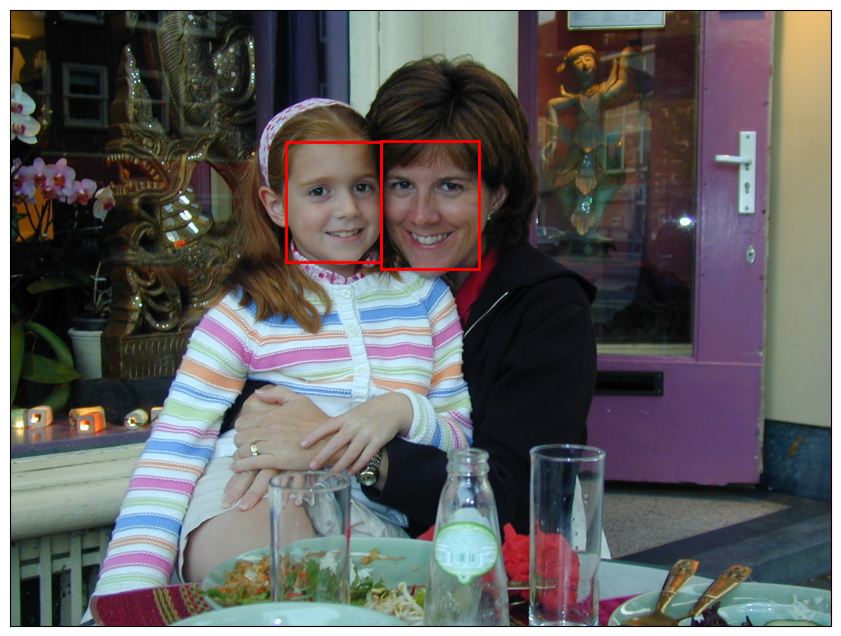

In [19]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

detector = MTCNN()
faces = detector.detect_faces(image)


for face in faces:
    if face['confidence'] > 0.998:
        x, y, w, h = face['box']
        rect = Rectangle((x,y), w, h, color='red', fill=False, lw=2)
        ax.add_patch(rect)

## Extracting Faces from Photos

In [26]:
from PIL import Image, ImageOps
import numpy as np

def extract_faces(input_file, min_confidence=0.9, crop=True):
    pil_image = Image.open(input_file)
    exif = pil_image.getexif()

    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]
    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    image = np.array(pil_image)

    detector = MTCNN()
    faces = detector.detect_faces(image)
    faces = [face for face in faces if face['confidence'] >= min_confidence]
    results = []

    for face in faces:
        x1, y1, w, h = face['box']

        if (crop):
            if w > h:
                x1 = x1 + ((w - h) // 2)
                w = h
            elif h > w:
                y1 = y1 + ((h - w) //2)
                h = w
        x2 = x1 + w
        y2 = y1 + h
        results.append(Image.fromarray(image[y1:y2, x1:x2]))

    return results

In [29]:
# code that saves faces in the folder, set to True to make it run
if False:
    faces = extract_faces('Data/cruise.jpg')

    for i, face in enumerate(faces):
        face.resize((224, 224)).save(f'face{i}.jpg')